# What can we learn about CA general permittees that terminated their NPDES permits, potentially in connection with the MMP statutory change in 2006?

We're specifically interested in Region 4.

<i> Ryan Treves

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
import yaml
from pathlib import Path
from policy_eval import main
from IPython.core.display_functions import clear_output
from policy_eval import scrape_facility_reports as sr

# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# display all columns
pd.set_option('display.max_columns', None)

# turn off warning messages
warnings.filterwarnings('ignore')

In [2]:
# This function takes in a comparison group, treatment group, and a column name,
# and returns the top n values of the column in order of the absolute difference
# in composition of the two groups. Streamlines compositional analysis.
def compare_composition(data_a, data_b, column, top_n=3):
    A = pd.DataFrame(data_a[column].value_counts(normalize=True)).rename(columns={column: 'Group A'})
    B = pd.DataFrame(data_b[column].value_counts(normalize=True)).rename(columns={column: 'Group B'})
    results = pd.concat([A, B], axis=1)
    results['diff'] = np.abs(results['Group A'] - results['Group B'])
    results = results.apply(lambda x: x.round(2))
    results.sort_values(by='diff', inplace=True, ascending=False)
    results = results.reset_index(names='Value').set_index(pd.Index([column] * len(results)))
    return results.head(top_n)

In [3]:
# Function to get SIC category. From reglab/third_party_dmr, see https://github.com/reglab/third_party_dmr/blob/73eb02f93caecaaf1441d98133dcfd3ac315e11d/scripts/utils.py#L23
def get_sic_category(sic):
    """
    Returns broad SIC category
        -1: sic code is NA
        0: agriculture, forestry and fishing
        1: mining
        2: construction
        3: manufacturing
        4: transportation, telecom
        5: utilities, other
        6: utilities, wastewater, sewage, water supply
        7: trade, retail etc.
        8: services
        9: public admin
    """
    if pd.isna(sic):
        return -1

    sic_two_digits = int(str(sic)[0:2])
    if sic_two_digits < 10:
        return 0
    if sic_two_digits < 15:
        return 1
    if sic_two_digits < 18:
        return 2
    if sic_two_digits < 40:
        return 3
    if sic_two_digits < 49:
        return 4
    if sic_two_digits < 50 and (sic < 4940 or sic > 4952) and sic < 4970:
        return 5
    if sic_two_digits < 40 and ((sic > 4940 and sic < 4953) or sic == 4971):
        return 6
    if sic_two_digits < 70:
        return 7
    if sic_two_digits < 90:
        return 8
    else:
        return 9

In [4]:
# Return the euclidean distance between to (x,y) tuples
def euclidean_distance(tup1, tup2):
    return np.sqrt(((tup1[0] - tup2[0]) ** 2) + ((tup1[1] - tup2[1])**2))

In [5]:
# Return the npdes_permit_id of the closest POTW to a given set of lat/long coordinates
def get_closest_potw(discharger_latlong, wwtp_table):
    closest_wwtp = ''
    closest_distance = 0
    for i in range(0, len(wwtp_table)):
        current_distance = euclidean_distance([wwtp_table['geocode_latitude'].iloc[i], wwtp_table['geocode_longitude'].iloc[i]], discharger_latlong)
        if closest_distance == 0 or current_distance < closest_distance:
            closest_distance = current_distance
            closest_wwtp = wwtp_table['npdes_permit_id'].iloc[i]
    return closest_wwtp

In [6]:
# Function to pick out facilities that may not be categorized as WWTPs by ICIS-NPDES
# but likely are WWTPs
def detect_wwtp_name(facility_name):
    """
    :param facility_name: str, name of facility
    :return: bool, 'True' if facility is likely a WWTP
    based on the facility name, 'False' if not
    """
    if pd.isna(facility_name):
        return np.nan
    facility_name = facility_name.lower()
    if ('wwtp' in facility_name or
        'wastewater' in facility_name or
        'treatment' in facility_name or
        'waste water' in facility_name
        # This last condition was in the original function from DMR integrity,
            # but I removed it because it was leading to false positives
        # or 'tp' in facility_name
        ):
        return True
    else:
        return False

In [7]:
# read in configuration file
with open(Path().resolve().parent / 'config.yml', 'r') as file:
    configs = yaml.safe_load(file)
CIWQS_data_path = Path(configs['CIWQS_data_path'])
ICIS_NPDES_data_path = Path(configs['ICIS_NPDES_data_path'])

In [8]:
# read in data
violations = pd.read_excel(CIWQS_data_path / 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str},
                           parse_dates=['OCCURRED ON', 'EFFECTIVE DATE', 'TERMINATION DATE'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements = pd.read_csv(CIWQS_data_path / 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1', 'ACL ISSUANCE DATE', 'EPL ISSUANCE DATE'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID'}, inplace=True)

In [9]:
# Load permit data
permit_data = pd.read_csv(ICIS_NPDES_data_path / 'CA_permits.csv',
                          parse_dates=['effective_date', 'issue_date', 'original_effective_date', 'original_issue_date',
                                       'expiration_date', 'retirement_date', 'termination_date'],
                          date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
# We are only looking for fixed covariates about each facility - thus we can drop information on different permit versions
permit_data.drop_duplicates('npdes_permit_id', inplace=True)
# Load facility data
facilities = pd.read_csv(ICIS_NPDES_data_path / 'CA_facilities.csv')
# Load SIC code data
sic_codes = pd.read_csv(ICIS_NPDES_data_path / 'CA_sic_codes.csv')

In [10]:
# Remove all enforcements with no MMP violations
enforcements = main.clean_enforcements(enforcements)
enforcements['EFFECTIVE DATE'] = pd.to_datetime(enforcements['EFFECTIVE DATE'], errors='coerce')

# Remove all dismissed and exempt violations
violations = main.clean_violations(violations, mmp_only=False)
# Separate out region 4 violations
region_4_violations = violations[violations['VIOLATED FACILITY REGION']==4]
del violations

In [11]:
# Option 1: load facility reports from saved file
region_4_facility_reports = pd.read_csv('region_4_facility_reports.csv', dtype={'FACILITY_ID': object}, parse_dates=['Effective Date', 'Expiration Date'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
# Option 2: Load facility reports for these facilities
# region_4_facility_reports = sr.scrape_facility_reports(list(region_4_violations['FACILITY_ID'].unique()), verbose=True)
# region_4_facility_reports.to_csv('region_4_facility_reports.csv')

In [12]:
# Calculate estimate entrance and exit dates
region_4_violations = main.get_facility_entrance_exit(region_4_facility_reports, region_4_violations)

Are facilities that terminated their permits around 2006 those with greater numbers of violations pre-2006?

In [13]:
# Group A: permittees that entered the population before 2006 and did not exit the population before 2012
group_a = region_4_violations[(region_4_violations['estimated_entrance_date']<pd.to_datetime('2006-01-01')) &
                              (region_4_violations['estimated_exit_date']>pd.to_datetime('2012-01-01'))]
print(len(group_a.drop_duplicates('FACILITY_ID')))

# Group B: permittees that entered the population before 2006, terminated their permits between 2006 and 2011,
# and actually exited the population at that point
group_b = region_4_violations[(region_4_violations['estimated_entrance_date']<pd.to_datetime('2006-01-01')) &
                              (region_4_violations['TERMINATION DATE']>pd.to_datetime('2006-01-01')) &
                              (region_4_violations['TERMINATION DATE']<pd.to_datetime('2011-01-01')) &
                              ((region_4_violations['TERMINATION DATE']) == (region_4_violations['estimated_exit_date']))]

dropout_facilities = group_b['FACILITY_ID'].unique()
print(len(dropout_facilities))

183
92


In [14]:
group_a[group_a['OCCURRED ON'] < pd.to_datetime('2006-01-01')].groupby('FACILITY_ID', as_index=False).nunique().agg(median_violation_count=pd.NamedAgg(column='VIOLATION ID (VID)', aggfunc=lambda x: x.median()), violation_count_sem=pd.NamedAgg(column='VIOLATION ID (VID)', aggfunc=lambda x: x.sem()))

,VIOLATION ID (VID)
median_violation_count,6.0000
violation_count_sem,19.9517


In [15]:
group_b[group_b['OCCURRED ON'] < pd.to_datetime('2006-01-01')].groupby('FACILITY_ID', as_index=False).nunique().agg(median_violation_count=pd.NamedAgg(column='VIOLATION ID (VID)', aggfunc=lambda x: x.median()), violation_count_sem=pd.NamedAgg(column='VIOLATION ID (VID)', aggfunc=lambda x: x.sem()))

,VIOLATION ID (VID)
median_violation_count,5.000000
violation_count_sem,1.743128


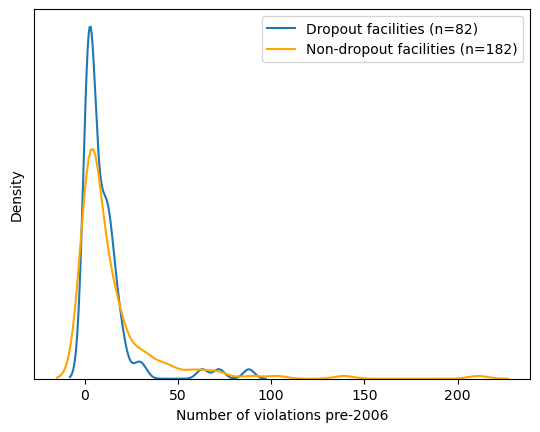

In [16]:
plt.style.use('default')
sns.kdeplot(data=group_b[(group_b['OCCURRED ON'] < pd.to_datetime('2006-01-01'))].groupby('FACILITY_ID', as_index=False).nunique(),
            x='VIOLATION ID (VID)', label='Dropout facilities (n=82)', bw=0.2);
sns.kdeplot(data=group_a[(group_a['OCCURRED ON'] < pd.to_datetime('2006-01-01')) &
                         (group_a['FACILITY_ID'] != '260420')].groupby('FACILITY_ID', as_index=False).nunique(),
            x='VIOLATION ID (VID)', color='orange', label='Non-dropout facilities (n=182)', bw=0.2);
plt.xlabel('Number of violations pre-2006')
plt.yticks([])
plt.legend();

Do their violation records pre-2006 differ in any other respects?

In [17]:
facility_results = pd.DataFrame()
for column in ['VIOLATION TYPE', 'MMP TYPE', 'VIOLATION SUBTYPE']:
    facility_results = pd.concat(
        [facility_results, compare_composition(group_a[group_a['OCCURRED ON'] < pd.to_datetime('2006-01-01')],
                                               group_b[group_b['OCCURRED ON'] < pd.to_datetime('2006-01-01')], column)])
facility_results.sort_values(by='diff', ascending=False, inplace=True)
facility_results

,Value,Group A,Group B,diff
VIOLATION SUBTYPE,OEV,0.47,0.21,0.27
MMP TYPE,Chronic,0.72,0.46,0.26
MMP TYPE,Serious,0.28,0.54,0.26
VIOLATION SUBTYPE,CAT1,0.35,0.55,0.19
VIOLATION SUBTYPE,CAT2,0.15,0.22,0.07
VIOLATION TYPE,Effluent,1.00,1.00,0.00


What about their enforcement histories?

In [18]:
enf_results = enforcements[enforcements['EFFECTIVE DATE']<pd.to_datetime('2006-01-01')].groupby('FACILITY_ID', as_index=False).sum()[['FACILITY_ID', 'TOTAL ASSESSMENT AMOUNT', 'INITIAL ASSESSED AMOUNT', 'LIABILITY $ AMOUNT']].merge(enforcements[enforcements['EFFECTIVE DATE']<pd.to_datetime('2006-01-01')].groupby('FACILITY_ID', as_index=False).nunique()[['FACILITY_ID', 'ENFORCEMENT ID (EID)']], on='FACILITY_ID')

enf_results['dropout_facility'] = enf_results['FACILITY_ID'].apply(lambda x: x in dropout_facilities)
enf_results.groupby('dropout_facility', as_index=False).median().rename(columns={'TOTAL ASSESSMENT AMOUNT': 'MEDIAN TOTAL ASSESSMENT AMOUNT', 'INITIAL ASSESSED AMOUNT': 'MEDIAN INITIAL ASSESSED AMOUNT', 'LIABILITY $ AMOUNT': 'MEDIAN LIABILITY $ AMOUNT', 'ENFORCEMENT ID (EID)': 'MEDIAN # ENFORCEMENTS'})

,dropout_facility,MEDIAN TOTAL ASSESSMENT AMOUNT,MEDIAN INITIAL ASSESSED AMOUNT,MEDIAN LIABILITY $ AMOUNT,MEDIAN # ENFORCEMENTS
0,False,27000.0,12000.0,18000.0,2.0
1,True,21000.0,18000.0,18000.0,1.0


Is it possible that individual facilities were prompted to drop out in response to receiving an enforcement action?

In [19]:
enforcements.merge(group_b[['FACILITY_ID', 'estimated_exit_date']], on='FACILITY_ID',)[['FACILITY_ID', 'estimated_exit_date', 'ACL ISSUANCE DATE']].drop_duplicates().dropna()

,FACILITY_ID,estimated_exit_date,ACL ISSUANCE DATE
0,231978,2008-02-29,2008-12-09
16,253495,2009-10-20,2010-10-18
40,269697,2007-11-09,2010-08-12
106,226543,2008-05-29,2010-06-30
173,271445,2008-01-17,2010-08-11
195,266920,2006-06-07,2001-09-26
223,261149,2008-11-06,2008-11-14
261,226291,2008-08-29,2008-12-02
273,238149,2010-03-11,2008-12-02
280,208078,2007-09-28,2008-12-09


In [20]:
enforcements[enforcements['ENFORCEMENT ACTION TYPE']=='Oral Communication'].merge(group_b[['FACILITY_ID', 'estimated_exit_date']], on='FACILITY_ID',)[['FACILITY_ID', 'estimated_exit_date', 'EFFECTIVE DATE']].drop_duplicates().dropna()

,FACILITY_ID,estimated_exit_date,EFFECTIVE DATE


How do the facilities compare?

In [21]:
facility_results = pd.DataFrame()
for column in ['AGENCY TYPE', 'PROGRAM', 'MAJOR-MINOR', 'VIOLATED FACILITY REGION']:
    facility_results = pd.concat(
        [facility_results, compare_composition(group_a.drop_duplicates('FACILITY_ID'),
                                               group_b.drop_duplicates('FACILITY_ID'), column)])
facility_results.sort_values(by='diff', ascending=False, inplace=True)
facility_results

,Value,Group A,Group B,diff
PROGRAM,NPDNONMUNIPRCS,0.64,0.89,0.25
MAJOR-MINOR,Minor,0.79,0.99,0.20
MAJOR-MINOR,Major,0.21,0.01,0.20
PROGRAM,NPDMUNILRG,0.13,0.01,0.11
AGENCY TYPE,County Agency,0.02,0.10,0.08
AGENCY TYPE,Special District,0.12,0.05,0.07
PROGRAM,NPDESWW,0.13,0.09,0.04
AGENCY TYPE,City Agency,0.16,0.13,0.03
VIOLATED FACILITY REGION,4,1.00,1.00,0.00


Group B is 99% minor facilities, and 89% NPDNONMUNIPRCS participants - much larger proportions than group A.

So what kind of facilities do we have in our dropout set?

In [41]:
group_b.drop_duplicates('FACILITY_ID')['FACILITY TYPE'].value_counts()

All other facilities    83
Industrial               6
Municipal/Domestic       1
Name: FACILITY TYPE, dtype: int64

In [45]:
group_b.drop_duplicates('FACILITY_ID')['PLACE TYPE'].value_counts()

Facility                              71
Service/Commercial                     8
Utility                                5
Residence/Education                    5
Recreational                           1
Manufacturing                          1
Industrial and Commercial Services     1
Name: PLACE TYPE, dtype: int64

In [46]:
group_b.drop_duplicates('FACILITY_ID')['PLACE SUBTYPE'].value_counts()

Groundwater Cleanup Site         19
Service/Commercial Site, NEC      6
Wastewater Treatment Facility     2
Residence, NEC                    2
Utility Structure                 2
Gasoline Service Station          2
Educational Facilities            2
Prison                            1
Swimming Pools                    1
Power Plant                       1
Manufacturing NEC                 1
Military Facility                 1
Name: PLACE SUBTYPE, dtype: int64

In [47]:
group_b.drop_duplicates('FACILITY_ID')['AGENCY TYPE'].value_counts()

Privately-Owned Business         61
City Agency                      12
County Agency                     9
Special District                  5
Federal Agency                    2
State Agency                      2
Government Agency Combination     1
Name: AGENCY TYPE, dtype: int64

In [48]:
group_b.drop_duplicates('FACILITY_ID')['SIC DESC 1'].value_counts()

Water Supply                                                                        12
Gasoline Service Stations                                                            9
Nonclassifiable Establishments                                                       6
General Government, NEC                                                              4
Products of Petroleum and Coal, NEC                                                  4
Operators of Apartment Buildings                                                     4
Petroleum Bulk Stations and Terminals                                                3
Tanks and Tank Components                                                            3
Heavy Construction, NEC                                                              2
General Contractors-Residential Buildings, Other Than Single-Family                  2
Facilities Support Management Services                                               2
Amusement and Recreation Services, NEC     

In [49]:
group_b.drop_duplicates('FACILITY_ID')['FACILITY WASTE TYPE'].value_counts()

Miscellaneous                   37
Contaminated ground water       33
Filter backwash brine waters     4
Stormwater runoff                3
Domestic wastewater              1
Uncontaminated ground water      1
Cooling water: Noncontact        1
Cooling water: Contact           1
Drilling muds                    1
Process waste, NEC               1
Name: FACILITY WASTE TYPE, dtype: int64

In [55]:
group_b.drop_duplicates('FACILITY_ID')['NPDES# CA#'].value_counts()

CAG994004    43
CAG834001    14
CAG994003    11
CAG914001     8
CAG994001     3
CAG994005     2
CA0059021     1
CA0060631     1
CAG674001     1
CA0002739     1
CA0057673     1
CA0001911     1
CA0002658     1
CA0057665     1
CA0056995     1
CA0062561     1
CA0059935     1
Name: NPDES# CA#, dtype: int64

In [58]:
group_b[group_b['NPDES# CA#']=='CAG994003'].drop_duplicates('FACILITY_ID')

,VIOLATED FACILITY REGION,REGULATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,NUMBER OF AGENCIES,PLACE ADDRESS,PLACE CITY,PLACE ZIP,PLACE COUNTY,PLACE LATITUDE,PLACE LONGITUDE,SIC CODE 1,SIC DESC 1,SIC CODE 2,SIC DESC 2,SIC CODE 3,SIC DESC 3,NAICS CODE 1,NAICS DESC 1,NAICS CODE 2,NAICS DESC 2,NAICS CODE 3,NAICS DESC 3,NUMBER OF PLACES,DESIGN FLOW,THREAT TO WATER QUALITY,COMPLEXITY,PRETREATMENT,FACILITY WASTE TYPE,FACILITY WASTE TYPE 2,FACILITY WASTE TYPE 3,FACILITY WASTE TYPE 4,PROGRAM,PROGRAM CATEGORY,NUMBER OF PROGRAMS,WDID,REG MEASURE ID,REG MEASURE TYPE,TITLE,DESCRIPTION,ORDER NUMBER,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,RECLAMATION,DREDGE FILL FEE,301H,APPLICATION FEE AMT RECEIVED,STATUS,STATUS DATE,EFFECTIVE DATE,EXPIRATION/REVIEW DATE,TERMINATION DATE,ADOPTION DATE,WDR REVIEW - AMEND,WDR REVIEW - REVISE/RENEW,WDR REVIEW - RESCIND,WDR REVIEW - NO ACTION REQUIRED,WDR REVIEW - PENDING,WDR REVIEW - PLANNED,STATUS ENROLLEE,INDIVIDUAL/GENERAL,FEE CODE,STAFF ASSIGNED,NUMBER OF STAFF ASSIGNED,SUPERVISOR,NUMBER OF SUPERVISORS,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,STATUS.1,OCCURRED ON,DISCOVERY DATE,PROGRAM.1,PROGRAM CATEGORY.1,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,QNCR Reportable,Violation Source,Violation Source ID,Violation Rank,Parameter,Limit,Result,Units,Period,Monitoring Location,Number of Final (A+H) 13267,Number of Final (A+H) 13308,Number of Final (A+H) ACL,Number of Final (A+H) CDO,Number of Final (A+H) CAO,Number of Final (A+H) Expedited Payment Letters,Number of Final (A+H) Referrals to Attorney General,Number of Final (A+H) Notices of Stormwater Noncompliance,Number of Final (A+H) Notices of Violation,Number of Final (A+H) Notices to Comply,Number of Final (A+H) Oral Communications,Number of Final (A+H) Referrals to District Attorney,Number of Final (A+H) Referrals to Other Agency,Number of Final (A+H) Referrals to Task Force,Number of Final (A+H) Referrals to USEPA,Number of Final (A+H) Settlement Court Orders,Number of Final (A+H) Staff Enforcement Letter,Number of Final (A+H) Stipulated Penalties,Number of Final (A+H) Third Party Actions,Number of Final (A+H) Time Schedule Orders,Number of Final (A+H) Unknown,Number of Final (A+H) Waste Discharge Requirements,enroll_date,final_expiration_date,last_termination_date,estimated_entrance_date,estimated_entrance_quarter,estimated_exit_date,estimated_exit_quarter,PLACE LATLONG,closest_POTW,TERMINATION YEAR
1205,4,4,234441,Juan Plant Site,Golden State Water Company - San Dimas,Facility,NaN,All other facilities,Privately-Owned Business,1.0,22317 Juan,Hawaiian Gardens,90716,Los Angeles,33.825766,-118.075198,4941.0,Water Supply,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.050,3.0,C,X - Facility is not a POTW,Filter backwash brine waters,NaN,NaN,NaN,NPDNONMUNIPRCS,NPDESWW,1.0,4B196400069,193935.0,Enrollee,"Enrollee - Golden State Water Company, Juan Pl...",NaN,R4-2004-0058,CAG994003,Minor,OTH,N - No,NaN,NaN,400.0,Historical,2010-02-22,2001-04-04,2011-12-31,2009-07-15,NaT,NaT,NaT,NaT,NaT,NaT,NaN,Y,I,15 - WDRs pending rescission,NaN,NaN,NaN,NaN,200647,Effluent,OEV,2Q01 effluent violation: Turbidity monthly av...,NaN,NaN,Violation,2001-06-06,2002-01-14 00:00:00,NPDNONMUNIPRCS,NPDESWW,N,N,N,N,NaN,NaN,N,Report,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaT,NaT,2009-07-15,2001-04-04,125,2009-07-15,158.0,"(33.825766, -118.075198)",CA0054119,2009
1208,4,4,217323,Century Plant,Golden State Water Company - San Dimas,Utility,Utility Structure,All other facilities,Privately-Owned Business,1.0,7128 Century Boulevard,Paramount,90723,Los Angeles,33.917389,-118.175422,4941.0,Water Supply,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.030,3.0,C,X - Facility is not a POTW,Miscellaneous,NaN,NaN,NaN,NPDNONMUNIPRCS,NPDESWW,1.0,4B196400070,193936.0,Enrollee,Enrollee (CI 8240

Let's map facilities that terminated their permits:

In [22]:
import ipyleaflet as ip
m = ip.Map(
    basemap=ip.basemaps.Esri.WorldImagery,
    center=[group_b.drop_duplicates('FACILITY_ID')['PLACE LATITUDE'].median(),
            group_b.drop_duplicates('FACILITY_ID')['PLACE LONGITUDE'].median()],
    zoom=10
    )
for i in range(0, len(group_b.drop_duplicates('FACILITY_ID'))):
    marker = ip.Marker(location=([group_b.drop_duplicates('FACILITY_ID')['PLACE LATITUDE'].iloc[i], group_b.drop_duplicates('FACILITY_ID')['PLACE LONGITUDE'].iloc[i]]), draggable=False)
    termination_year = group_b.drop_duplicates('FACILITY_ID')['TERMINATION DATE'].dt.year.iloc[i]
    marker.icon = ip.AwesomeIcon(name='circle', marker_color=['red', 'green', 'blue', 'purple'][termination_year % 4])
    marker.title = group_b.drop_duplicates('FACILITY_ID')['FACILITY NAME'].iloc[i]
    m.add_layer(marker);
m

Map(center=[34.0566005, -118.286771], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

What does the map of non-droupout facilities look like in comparison?

In [23]:
m2 = ip.Map(
    basemap=ip.basemaps.Esri.WorldImagery,
    center=[group_a.drop_duplicates('FACILITY_ID')['PLACE LATITUDE'].median(),
            group_a.drop_duplicates('FACILITY_ID')['PLACE LONGITUDE'].median()],
    zoom=10
    )
for i in range(0, len(group_b.drop_duplicates('FACILITY_ID'))):
    marker = ip.Marker(location=([group_a.drop_duplicates('FACILITY_ID')['PLACE LATITUDE'].iloc[i], group_a.drop_duplicates('FACILITY_ID')['PLACE LONGITUDE'].iloc[i]]), draggable=False)
    marker.title = group_a.drop_duplicates('FACILITY_ID')['FACILITY NAME'].iloc[i]
    m2.add_layer(marker);
m2

Map(center=[34.046462, -118.32694], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Let's find the nearest POTW to each facility that terminated its permit:

In [24]:
facilities_merged = facilities.merge(permit_data, on=['npdes_permit_id', 'permit_state'], how='outer').merge(sic_codes, on='npdes_permit_id', how='outer')
del facilities

facilities_merged['sic_category'] = facilities_merged['sic_code'].apply(get_sic_category)

# Detect facilities which may not be categorized as WWTPs by ICIS-NPDES but likely are in reality
facilities_merged['likely_wwtp'] = facilities_merged['facility_name'].apply(lambda x: detect_wwtp_name(x))

In [25]:
# Retain only POTWs
POTWs = facilities_merged[(facilities_merged['facility_type_indicator'] == 'POTW')]
# # Optional: retain only POTWs in Ventura/LA county
# POTWs = POTWs[POTWs['county_code'].apply(lambda x: x in ['CA111', 'CA037'])]

In [26]:
len(POTWs)

335

How does this list of likely WWTPs map to our list of WWTPs in region 4 from the SWRCB's WWTP contact sheet (https://www.waterboards.ca.gov/water_issues/programs/npdes/docs/wwtpcontactinfo.xlsx) ?

In [27]:
POTWs['in_ICIS_list'] = True
SWRCB_wwtp_contact_list = pd.DataFrame(data = {'npdes_permit_id':['CA0056014','CA0060577','CA0109991','CA0061191','CA0055531','CA0053953','CA0056227','CA0064556','CA0063401','CA0054011','CA0054119','CA0110175','CA0054372','CA0053619','CA0054216','CA0064068','CA0054313','CA0053716','CA0053856','CA0053911','CA0059099','CA0064246','CA0063274','CA0061794','CA0053597','CA0053961','CA0054097','CA0059501','CA0055221','CA0056294','CA0053651']})
SWRCB_wwtp_contact_list['in_contact_list'] = True

In [28]:
POTWs = POTWs.merge(SWRCB_wwtp_contact_list, on='npdes_permit_id', how='outer')

How do these lists map to the list of Wastewater Treatment Facilities in Region 4 from CIWQS's Regulated Facility Report (https://ciwqs.waterboards.ca.gov/ciwqs/readOnly/CiwqsReportServlet?reportID=6148270&inCommand=drilldown&reportName=RegulatedFacilityDetail&place=4)?

In [29]:
POTW_from_regulated_facility_report = pd.read_csv('/Users/rtreves/Documents/RegLab/python_projects/ca_mmp/policy_eval/wwtps_from_regulated_facility_report.csv').rename(columns={'NPDES No.': 'npdes_permit_id'})
POTW_from_regulated_facility_report['in_RFR_list'] = True
POTWs = POTWs.merge(POTW_from_regulated_facility_report[['npdes_permit_id', 'Facility Name', 'Latitude', 'Longitude', 'in_RFR_list']], on='npdes_permit_id', how='outer')

In [30]:
POTWs['in_contact_list'].fillna(False, inplace=True)
POTWs['in_RFR_list'].fillna(False, inplace=True)
POTWs['in_ICIS_list'].fillna(False, inplace=True)

In [31]:
pd.DataFrame(POTWs[POTWs['county_code'].apply(lambda x: x in ['CA111', 'CA037'])][['in_ICIS_list', 'in_contact_list', 'in_RFR_list']].value_counts())

0
in_ICIS_list in_contact_list in_RFR_list    
True         True            False        13
                             True         11
             False           False         5
                             True          1

Let's find the closest POTW to each facility, based on the ICIS-NPDES POTW list only:

In [32]:
# Combine latitude and longitude into one tuple
group_a['PLACE LATLONG'] = list(zip(group_a['PLACE LATITUDE'], group_a['PLACE LONGITUDE']))
group_b['PLACE LATLONG'] = list(zip(group_b['PLACE LATITUDE'], group_b['PLACE LONGITUDE']))

In [33]:
# Manual cleaning data entry errors:
group_b['PLACE LATLONG'][17307] = (34.175286, -118.168962)
group_b['PLACE LATLONG'][5756] = (34.425000, -118.538333)
group_b['PLACE LATLONG'][14541] = (34.425000, -118.538333)
group_b['PLACE LATLONG'][15171] = (34.078056, -118.335556)

In [34]:
# group_a['closest_POTW'] = group_a['PLACE LATLONG'].apply(lambda x: get_closest_wwtp(x, facilities_merged))
group_b['closest_POTW'] = group_b['PLACE LATLONG'].apply(lambda x: get_closest_potw(x, POTWs[POTWs['in_ICIS_list']]))

Do facilities with the same closest WWTP terminate their permits around the same time?

In [35]:
group_b['TERMINATION YEAR'] = group_b['TERMINATION DATE'].dt.year
wwtp_grouped = group_b.groupby('closest_POTW', as_index=False).nunique()[['closest_POTW', 'TERMINATION YEAR', 'FACILITY NAME']]
wwtp_grouped

,closest_POTW,TERMINATION YEAR,FACILITY NAME
0,CA0053619,3,3
1,CA0053651,2,4
2,CA0053716,3,3
3,CA0053813,3,5
4,CA0053856,3,5
5,CA0053911,1,2
6,CA0053953,5,15
7,CA0054011,4,9
8,CA0054097,3,5
9,CA0054119,4,9


In [36]:
# Save group_b geodata
group_b[['FACILITY_ID', 'PLACE LATITUDE', 'PLACE LONGITUDE', 'PLACE LATLONG', 'closest_POTW_latitude', 'closest_POTW_longitude', 'closest_POTW_latlong']].to_csv('group_b.csv')

KeyError: "['closest_POTW_latitude', 'closest_POTW_longitude', 'closest_POTW_latlong'] not in index"

Unfortunately, overlaying the LA City sewersheds map with this data in ArcGIS online (https://arcg.is/1OeySa0) reveals that closest POTW based on euclidean distance is not the most accurate for matching facilities to POTWs. Using the sewersheds, we can assign facilities manually. Here, NA values are assigned to facilities that are closest to a POTW in the LA City service area, but not in a LA city sewershed.

In [ ]:
sewershed_matching = pd.DataFrame(data={'FACILITY_ID': ['273407','229285','216584','220088','260234','225801',
                                                        '261149', '270822', '243177', '242194', '269780', '273405',
                                                        '216599', '273599', '245135', '221439', '231825', '226298',
                                                        '253472', '201355', '225925', '226170', '254054', '267467',
                                                        '208478', '271445', '229130', '273372', '268840', '267290',
                                                        '274353', '262164', '274352', '207724', '238149', '260743',
                                                        '262221', '250384', '251305', '250804', '217058', '266958',
                                                        '231758', '271483', '229012', '268714', '250017', '226271',
                                                        '262247', '250523', '274403', '217490', '245218', '663217',
                                                        '207966', '226543', '217323', '243558', '269697', '260969',
                                                        '226291', '256068', '256069', '212325', '226504', '207671',
                                                        '266921', '261873'],
                                        'POTW_sewershed': ['CA0056227','CA0053953','CA0053856','CA0053856',
                                                           'CA0053856','CA0053856', 'CA0109991','CA0109991',
                                                           'CA0109991','CA0109991', 'CA0109991','CA0109991',
                                                           'CA0109991','CA0109991','CA0109991','CA0109991',
                                                           'CA0109991','CA0109991','CA0109991','CA0109991',
                                                           'CA0109991','CA0109991', 'CA0109991','CA0109991',
                                                           'CA0109991','CA0109991', 'CA0109991','CA0109991',
                                                           'CA0109991','CA0109991', 'CA0109991','CA0109991',
                                                           'CA0109991','CA0109991', 'CA0109991', 'CA0109991',
                                                           'CA0109991', 'CA0053813', 'CA0053813', 'CA0053813',
                                                           'CA0053813','CA0053813', 'CA0053813', 'CA0053813',
                                                           'CA0053813', 'CA0053813', 'CA0053813', 'CA0053813',
                                                           'CA0053813', 'CA0053813', 'CA0053813', 'CA0053813',
                                                           'CA0053813', 'CA0053813', 'CA0053813', 'CA0053813',
                                                           'CA0053813', 'CA0053813', 'CA0053813', 'CA0053813',
                                                           'CA0053813', 'CA0053813', 'CA0053813', 'CA0053813',
                                                           'CA0053813', 'CA0053813', 'CA0053813', 'CA0053813']})

group_b = group_b.merge(sewershed_matching, on='FACILITY_ID', how='left')

Let's map each facility, with a line to its matched POTW:

In [ ]:
# Get lat/longs of closest POTW
group_b = group_b.merge(POTWs[['npdes_permit_id', 'geocode_latitude', 'geocode_longitude']],
                        left_on='POTW_sewershed', right_on='npdes_permit_id').rename(columns={
    'geocode_latitude':'POTW_sewershed_latitude', 'geocode_longitude':'POTW_sewershed_longitude'
})
group_b['POTW_sewershed_latlong'] = list(zip(group_b['POTW_sewershed_latitude'], group_b['POTW_sewershed_longitude']))

In [ ]:
to_plot = group_b.dropna(subset='POTW_sewershed')

m3 = ip.Map(
    basemap=ip.basemaps.Esri.WorldImagery,
    center=[to_plot.drop_duplicates('FACILITY_ID')['PLACE LATITUDE'].median(),
            to_plot.drop_duplicates('FACILITY_ID')['PLACE LONGITUDE'].median()],
    zoom=10
    )
for i in range(0, len(to_plot.drop_duplicates('FACILITY_ID'))):
    # Add marker for facility
    place_marker = ip.Marker(location=(to_plot.drop_duplicates('FACILITY_ID')['PLACE LATLONG'].iloc[i]), draggable=False)
    place_marker.icon = ip.AwesomeIcon(name='circle', marker_color='red')
    place_marker.title = to_plot.drop_duplicates('FACILITY_ID')['FACILITY NAME'].iloc[i]
    m3.add_layer(place_marker);

    # Draw lines to matched wwtps
    line = ip.Polyline(locations = [to_plot.drop_duplicates('FACILITY_ID')['PLACE LATLONG'].iloc[i],
                                    to_plot.drop_duplicates('FACILITY_ID')['POTW_sewershed_latlong'].iloc[i]],
                       color='blue', fill=False)
    m3.add_layer(line);

    # Draw marker at closest wwtp
    wwtp_marker = ip.Marker(location=(to_plot.drop_duplicates('FACILITY_ID')['POTW_sewershed_latlong'].iloc[i]), draggable=False)
    wwtp_marker.icon = ip.AwesomeIcon(name='tint', marker_color='blue')
    wwtp_marker.title = to_plot.drop_duplicates('FACILITY_ID')['POTW_sewershed'].iloc[i]
    m3.add_layer(wwtp_marker);
m3

What effluents are our dropout facilities discharging?

In [ ]:
dmrs = pd.read_csv(ICIS_NPDES_data_path / 'CA_dmrs.csv', parse_dates=['monitoring_period_end_date'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
dropout_permit_ids = group_b['NPDES# CA#'].unique()
dropout_dmrs = dmrs[dmrs['npdes_permit_id'].apply(lambda x: x in dropout_permit_ids)]

In [ ]:
len(dropout_dmrs.drop_duplicates('npdes_permit_id'))

Unfortunately, we only have DMR data for one of our dropout facilities. Cross-checking reveals the same missingness in CIWQS eSMR records as well.

Do we see an increase in NPDES exceedances in matched POTWs after dropout facilities terminate their permits?

In [ ]:
# Find just dmrs from matched WWTPs
matched_POTW_permit_ids = list(group_b['POTW_sewershed'].unique())
matched_POTW_dmrs = dmrs[dmrs['npdes_permit_id'].apply(lambda x: x in matched_POTW_permit_ids)]
del dmrs
# Retain only instances where DMR value exceeds limit value
matched_POTW_dmrs = matched_POTW_dmrs[matched_POTW_dmrs['dmr_value_standard_units'] > matched_POTW_dmrs['limit_value_standard_units']]

In [ ]:
# Merge in exit date from nearby facilites
matched_POTW_dmrs = matched_POTW_dmrs.merge(group_b[['FACILITY_ID', 'estimated_exit_date', 'POTW_sewershed']].drop_duplicates(), left_on='npdes_permit_id', right_on='POTW_sewershed')
matched_POTW_dmrs.rename(columns={'FACILITY_ID': 'Matched dropout facility'}, inplace=True)

In [ ]:
# Determine relative date of exceedance(s)
matched_POTW_dmrs['1yrs_pre_exit'] = (matched_POTW_dmrs['estimated_exit_date'].dt.to_period('M').astype(int) > matched_POTW_dmrs['monitoring_period_end_date'].dt.to_period('M').astype(int)) & (matched_POTW_dmrs['estimated_exit_date'].dt.to_period('M').astype(int) < matched_POTW_dmrs['monitoring_period_end_date'].dt.to_period('M').astype(int) + 12)
matched_POTW_dmrs['1yrs_post_exit'] = (matched_POTW_dmrs['estimated_exit_date'].dt.to_period('M').astype(int) < matched_POTW_dmrs['monitoring_period_end_date'].dt.to_period('M').astype(int)) & (matched_POTW_dmrs['estimated_exit_date'].dt.to_period('M').astype(int) > matched_POTW_dmrs['monitoring_period_end_date'].dt.to_period('M').astype(int) - 12)

matched_POTW_dmrs['2yrs_pre_exit'] = (matched_POTW_dmrs['estimated_exit_date'].dt.to_period('M').astype(int) > matched_POTW_dmrs['monitoring_period_end_date'].dt.to_period('M').astype(int)) & (matched_POTW_dmrs['estimated_exit_date'].dt.to_period('M').astype(int) < matched_POTW_dmrs['monitoring_period_end_date'].dt.to_period('M').astype(int) + 24)
matched_POTW_dmrs['2yrs_post_exit'] = (matched_POTW_dmrs['estimated_exit_date'].dt.to_period('M').astype(int) < matched_POTW_dmrs['monitoring_period_end_date'].dt.to_period('M').astype(int)) & (matched_POTW_dmrs['estimated_exit_date'].dt.to_period('M').astype(int) > matched_POTW_dmrs['monitoring_period_end_date'].dt.to_period('M').astype(int) - 24)

In [ ]:
# Group by WWTP
matched_POTW_dmrs_grouped = matched_POTW_dmrs.groupby(['npdes_permit_id', 'Matched dropout facility'], as_index=False).sum()[['npdes_permit_id', 'Matched dropout facility', '1yrs_pre_exit', '1yrs_post_exit', '2yrs_pre_exit', '2yrs_post_exit']]

In [ ]:
(matched_POTW_dmrs_grouped['2yrs_post_exit'] > matched_POTW_dmrs_grouped['2yrs_pre_exit']).value_counts()

In [ ]:
matched_POTW_dmrs_grouped['1yr_diff'] = matched_POTW_dmrs_grouped['1yrs_post_exit'] - matched_POTW_dmrs_grouped['1yrs_pre_exit']
matched_POTW_dmrs_grouped['2yr_diff'] = matched_POTW_dmrs_grouped['2yrs_post_exit'] - matched_POTW_dmrs_grouped['2yrs_pre_exit']

In [ ]:
matched_POTW_dmrs_grouped.groupby('npdes_permit_id', as_index=False).mean()[['npdes_permit_id', '1yr_diff', '2yr_diff']]

In [ ]:
matched_POTW_dmrs_grouped.groupby('npdes_permit_id', as_index=False).mean()[['npdes_permit_id', '1yrs_pre_exit', '1yrs_post_exit', '2yrs_pre_exit', '2yrs_post_exit']]

Do we see any changes in flow at the downstreatm POTW before/after the facilities drop out?

In [ ]:
flow_data = pd.read_csv(ICIS_NPDES_data_path / 'LA_potw_flow_data.csv',
                        dtype={'perm_feature_nmbr': object},
                        parse_dates=['monitoring_period_end_date'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))

In [ ]:
sns.lineplot(flow_data[(flow_data['statistical_base_code']=='MK') &
                       (flow_data['npdes_permit_id']=='CA0053813') &
                       (flow_data['monitoring_period_end_date'] > pd.to_datetime('2005-01-01')) &
                       (flow_data['monitoring_period_end_date'] < pd.to_datetime('2011-01-01'))], x='monitoring_period_end_date', y='dmr_value_nmbr', hue='perm_feature_nmbr')
plt.vlines(x=group_b[group_b['POTW_sewershed']=='CA0053813']['estimated_exit_date'], ymin=0, ymax=400, linestyle='--', color='silver')
plt.legend(title='Outfall')
plt.title('Joint Water Pollution Control Plant (CA0053813, Place ID 234156)')
plt.ylabel('Million gallons / day, monthly average');
plt.xlabel('');
plt.savefig('JPCP.png', dpi=300)

In [ ]:
sns.lineplot(flow_data[(flow_data['statistical_base_code']=='MK') &
                       (flow_data['npdes_permit_id']=='CA0053856') &
                       (flow_data['monitoring_period_end_date'] > pd.to_datetime('2005-01-01')) &
                       (flow_data['monitoring_period_end_date'] < pd.to_datetime('2011-01-01'))], x='monitoring_period_end_date', y='dmr_value_nmbr', hue='perm_feature_nmbr')
plt.vlines(x=group_b[group_b['POTW_sewershed']=='CA0053856']['estimated_exit_date'], ymin=10, ymax=20, linestyle='--', color='silver');
plt.legend(title='Outfall')
plt.title('Terminal Island (CA0053856, Place ID 267130)')
plt.ylabel('Million gallons / day, monthly average');
plt.xlabel('');
plt.savefig('Terminal.png', dpi=300)

In [ ]:
sns.lineplot(flow_data[(flow_data['statistical_base_code']=='MK') &
                       (flow_data['npdes_permit_id']=='CA0053953') &
                       (flow_data['monitoring_period_end_date'] > pd.to_datetime('2009-01-01')) &
                       (flow_data['monitoring_period_end_date'] < pd.to_datetime('2013-01-01'))], x='monitoring_period_end_date', y='dmr_value_nmbr', hue='perm_feature_nmbr')
plt.vlines(x=group_b[group_b['POTW_sewershed']=='CA0053953']['estimated_exit_date'], ymin=0, ymax=50, linestyle='--', color='silver');
plt.legend(title='Outfall')
plt.title('LA-Glendale WWRP (CA0053953, Place ID 235738)')
plt.ylabel('Million gallons / day, monthly average');
plt.xlabel('');
plt.savefig('LA-Glendale.png', dpi=300)

In [ ]:
sns.lineplot(flow_data[(flow_data['statistical_base_code']=='MK') &
                       (flow_data['npdes_permit_id']=='CA0056227') &
                       (flow_data['monitoring_period_end_date'] > pd.to_datetime('2005-01-01')) &
                       (flow_data['monitoring_period_end_date'] < pd.to_datetime('2011-01-01'))], x='monitoring_period_end_date', y='dmr_value_nmbr', hue='perm_feature_nmbr')
plt.vlines(x=group_b[group_b['POTW_sewershed']=='CA0056227']['estimated_exit_date'], ymin=0, ymax=80, linestyle='--', color='silver');
plt.legend(title='Outfall')
plt.title('DCT WWRP (CA0056227, Place ID 267571)')
plt.ylabel('Million gallons / day, monthly average');
plt.xlabel('');
plt.savefig('DCT.png', dpi=300)

In [ ]:
sns.lineplot(flow_data[(flow_data['statistical_base_code']=='MK') &
                       (flow_data['npdes_permit_id']=='CA0109991') &
                       (flow_data['monitoring_period_end_date'] > pd.to_datetime('2005-01-01')) &
                       (flow_data['monitoring_period_end_date'] < pd.to_datetime('2011-01-01'))], x='monitoring_period_end_date', y='dmr_value_nmbr', hue='perm_feature_nmbr')
plt.vlines(x=group_b[group_b['POTW_sewershed']=='CA0109991']['estimated_exit_date'], ymin=0, ymax=400, linestyle='--', color='silver');
plt.legend(title='Outfall')
plt.title('Hyperion WWTP (CA0109991, Place ID 232063')
plt.ylabel('Million gallons / day, monthly average');
plt.xlabel('');
plt.savefig('Hyperion.png', dpi=300)